In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from scipy.spatial import distance
# from scipy.sparse.csgraph import minimum_spanning_tree
import math
import pickle
import time
import pandas as pd


## USING PREVIOUS DATA

We want to be able to save thing 

IF Pickled = True then we will previously simulated data using the pickle packge

In [2]:
PICKLED = True

##### set parent directory

In [3]:
import os

# Get the current working directory
current_directory = os.getcwd()
# print("Current Directory:", current_directory)

# Move to the parent directory
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

# Print the updated working directory
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Updated Directory: /mnt/c/users/rjmay/code/research_ms


In [4]:
# os.chdir(os.getcwd() + "/code/research_ms")


### Simulation stage

In [5]:
from modules.multi_bounds_v2 import bounds_class
from modules.Bhatt_knn_func import knn_num_calc

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
mean_sep = np.linspace(0, 5, 10000 , endpoint = True)


In [7]:
exact = []

for i in mean_sep:
    dx = 0.001
    x = np.arange(-5, 8 + dx, dx)
    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - i)**2) / np.sqrt(2 * np.pi)
    fmin = np.minimum(f0, f1)
    BER = 0.5 * np.sum(fmin * dx)
    exact.append(BER)

#     print("BER 2d:", BER)

In [8]:
x = np.linspace(0,.5, 21, endpoint = True) ## this is the desired mean BER points to be calculated at 

new_mean_sep = [] 
for j in x:
    index = (np.abs(j - np.array(exact) )).argmin()
    new_mean_sep.append(mean_sep[index])

In [9]:
mean_sep = new_mean_sep

In [10]:
bound_obj_lst = []
bound_obj_lst2 = []


if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:

    MC_num = 400
    sample_size= 500


    for i in mean_sep:

        start = time.time()
        dim =3 
        mean1 = np.zeros(dim)
        covariance1 = np.identity(dim)
        mean2 = np.zeros(dim)
        mean2[0] = i
        covariance2= np.identity(dim)

        
        sample_size= 500
        n0, n1 = sample_size, sample_size
        
        
        k = knn_num_calc(n0, len(mean1))

        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]

        bounds = bounds_class("mv_normal", params1, params2, threads =2,  MC_num = MC_num, k_nn=k)
        
        print("done with 3d ", end = " ")
        dim = 8
        mean1 = np.zeros(dim)
        covariance1 = np.identity(dim)
        mean2 = np.zeros(dim)
        mean2[0] = i
        covariance2= np.identity(dim)

        
        bound_obj_lst.append(bounds)
        
        sample_size= 500
        n0, n1 = sample_size, sample_size
        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]        
        k = knn_num_calc(n0, len(mean1))

        
        bounds2 = bounds_class("mv_normal", params1, params2, threads =2,  MC_num = MC_num, k_nn =k )

        bound_obj_lst2.append(bounds2)
        
        
        end = time.time()
        
        print("done with ", i, " in ",  end -start )



USING PREVIOUS DATA NOT SIMULATING DATA 


##### Pickling
This is where the data either gets save or loaded

In [11]:
file_path = 'sim_data/means_sep_as_BER_v3.pkl' # DONT FORGET TO CHANGE ME IF YOU COPY AND PASTE


if PICKLED  == False:
    
    objects_to_save = bound_obj_lst, bound_obj_lst2


    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    bound_obj_lst, bound_obj_lst2 = loaded_objects

Loaded object successfully


## Using the data

may or not be pickled. 

In [12]:
exact = []

for i in mean_sep:
    dx = 0.001
    x = np.arange(-5, 8 + dx, dx)

    f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
    f1 = np.exp(-0.5 * (x - i)**2) / np.sqrt(2 * np.pi)

    fmin = np.minimum(f0, f1)

    BER = 0.5 * np.sum(fmin * dx)
    
    exact.append(BER)

#     print("BER 2d:", BER)

### Plotting using dim 3

In [13]:
df = pd.DataFrame([obj() for obj in bound_obj_lst], index = exact)


# df

In [14]:
fs = 14
dpi =300

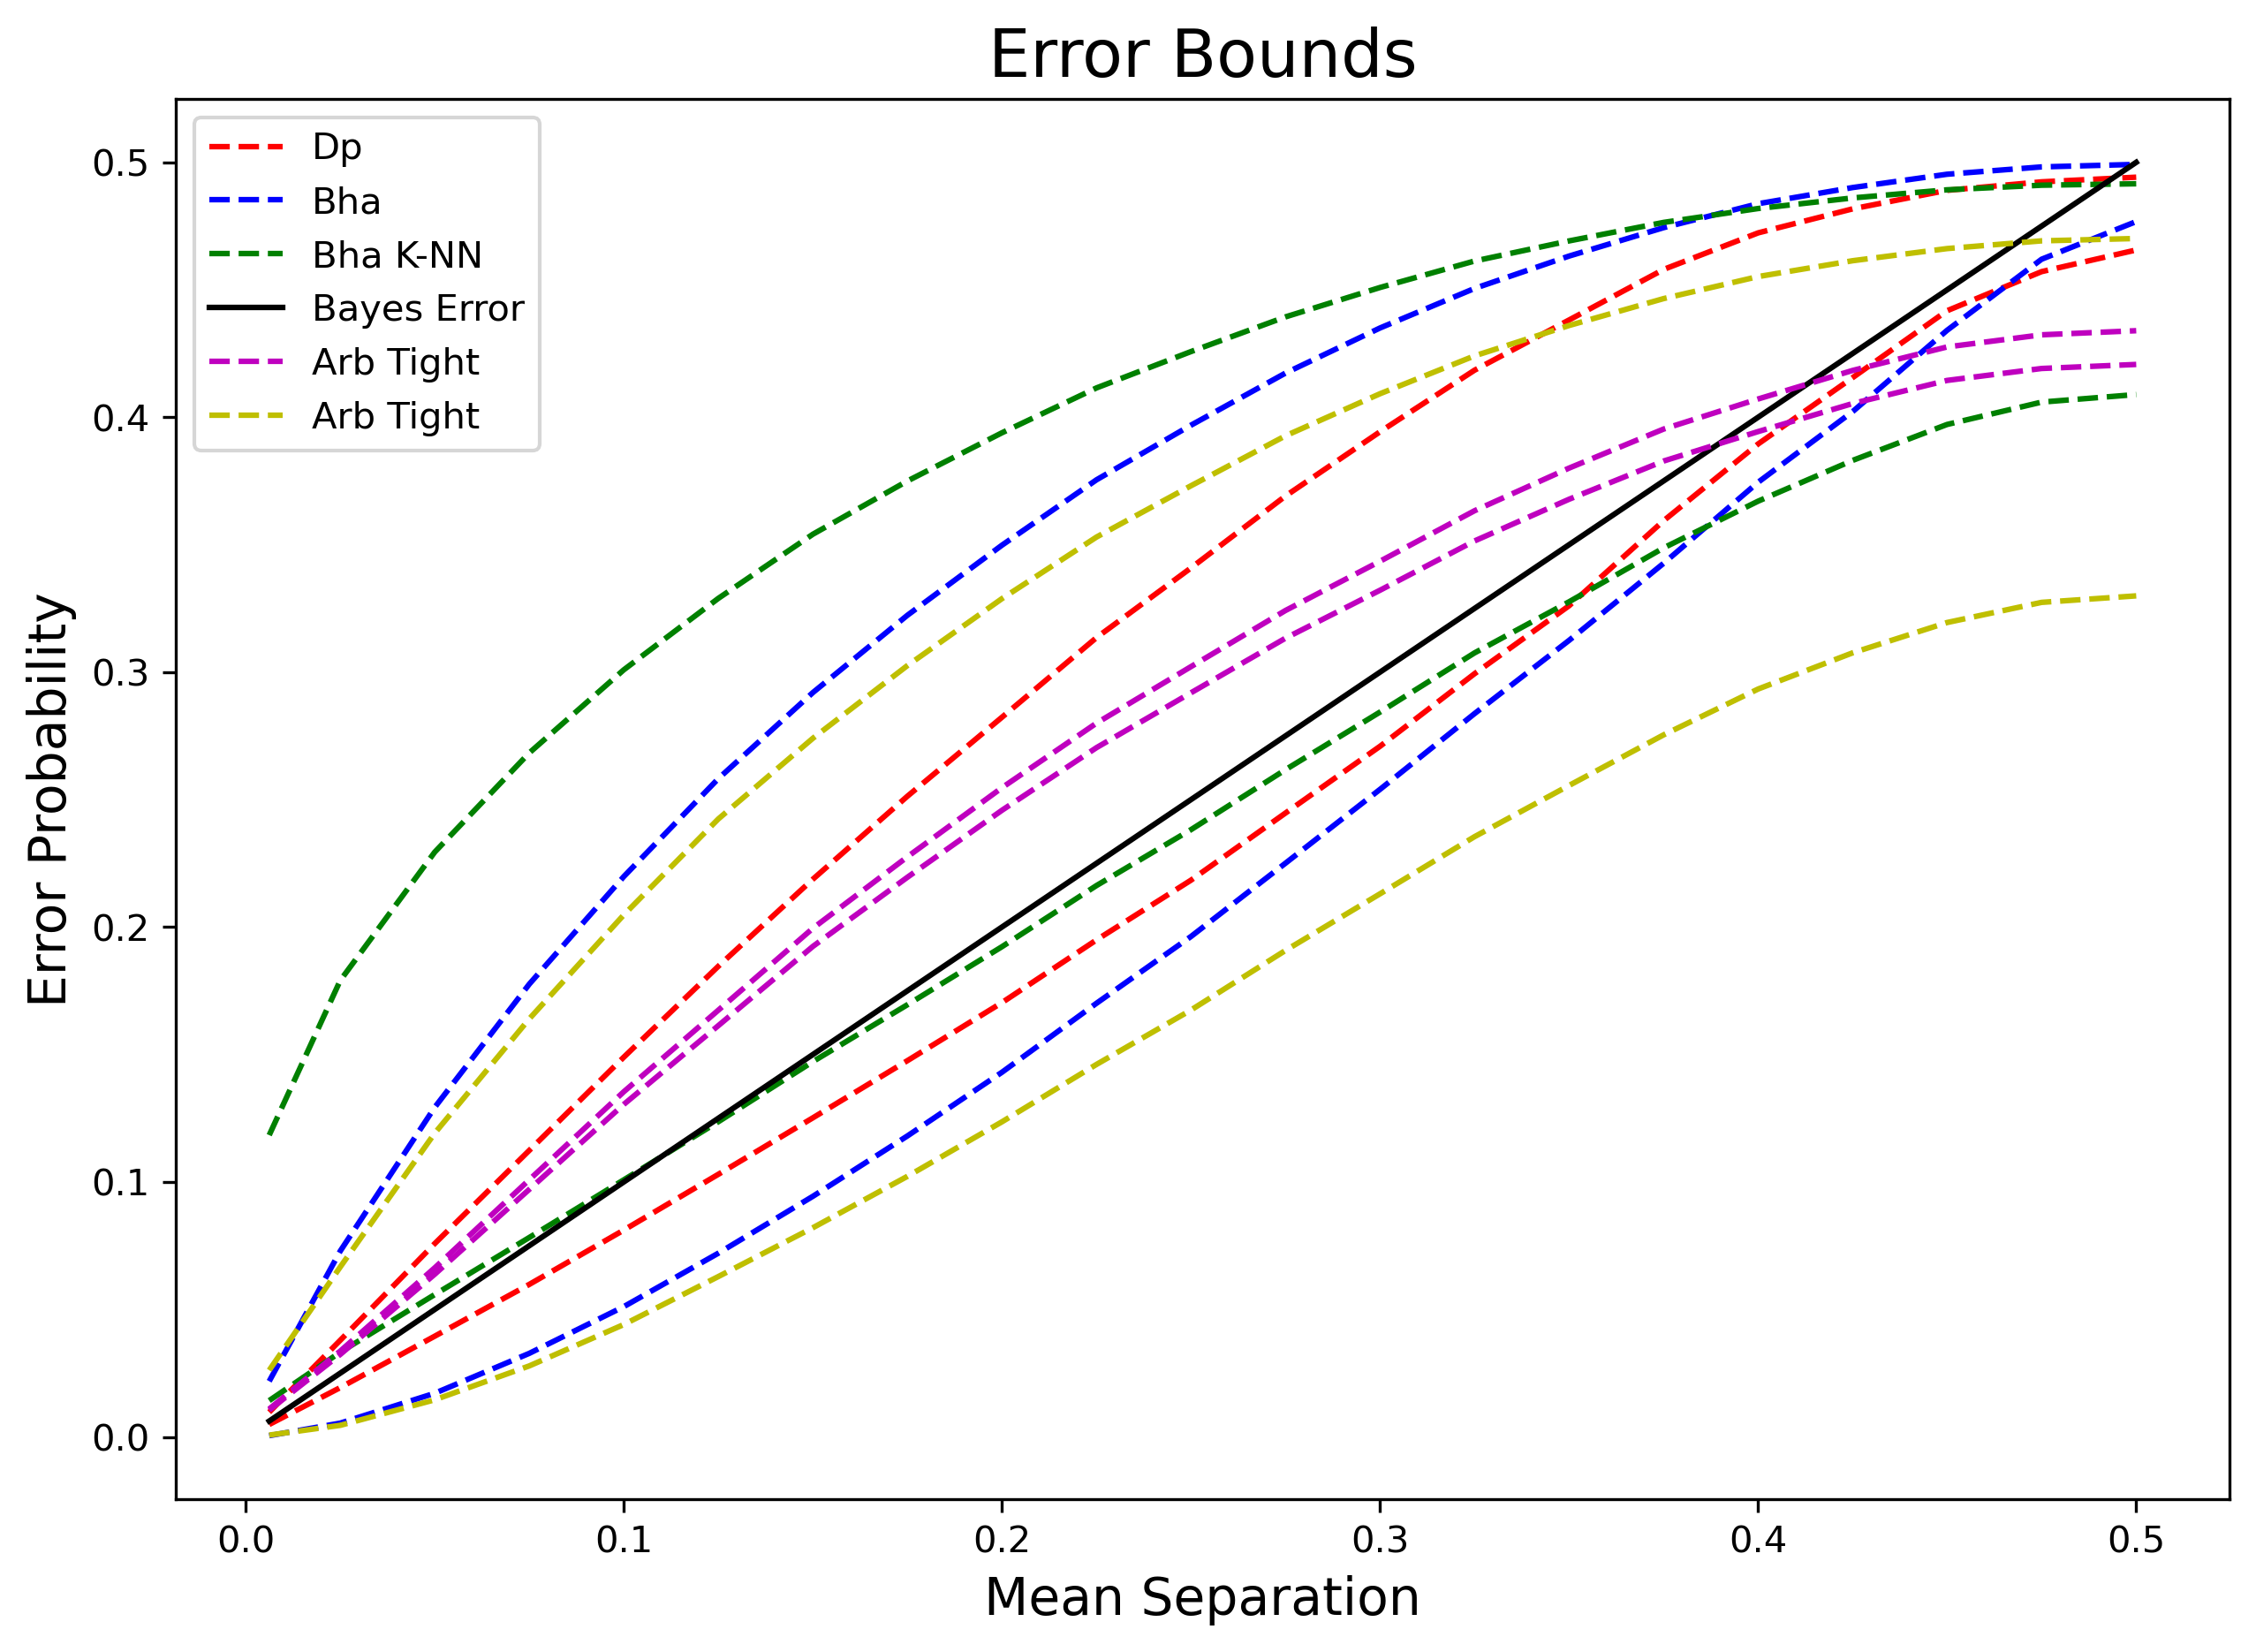

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7), dpi = dpi)

# Plot Dp
ax.plot(df["Dp_lower"], 'r--', label='Dp')
ax.plot(df["Dp_upper"], 'r--')

# Plot Bha
ax.plot(df["Bha_lower"], 'b--', label='Bha')
ax.plot(df["Bha_upper"], 'b--')

# Plot Bha K-NN
ax.plot(df["Bha_knn_lower"], 'g--')
ax.plot(df["Bha_knn_upper"], 'g--', label='Bha K-NN')

# Plot Bayes Error
ax.plot(exact, exact, 'k', label='Bayes Error')

# Plot Lower and Upper G_a
ax.plot(df["tight_lower"], 'm--', label="Arb Tight")
ax.plot(df["tight_upper"], 'm--')


# Plot Maha
# ax.plot( df["Maha_upper"], 'y--', label='Maha')
# ax.scatter(df.index, df["Maha_upper"], color='y', marker='*')

# Plot Lower and Upper G_a
ax.plot(df["inf_lower"], 'y--', label="Arb Tight")
ax.plot(df["inf_upper"], 'y--')



ax.set_xlabel("Mean Separation", fontsize=fs)
ax.set_ylabel("Error Probability", fontsize=fs)
ax.set_title("Error Bounds", fontsize=fs + 4)
ax.legend()

plt.show()


In [16]:
validity_lst  =[]
for i in range(len(exact)):
    validity_lst.append(bound_obj_lst[i].validity(exact[i]))
    
import pandas as pd
df = pd.DataFrame(validity_lst, index = exact)
# df

,Dp_lower,Dp_upper,Bha_lower,Bha_upper,Bha_knn_lower,Bha_knn_upper,tight_lower,tight_upper,Maha_upper,inf_lower,inf_upper
0.006210,0.7925,0.8025,1.0000,1.000,0.0000,1.0,0.0000,1.0000,1.0,1.0,1.00
0.025001,0.9075,0.9450,1.0000,1.000,0.0000,1.0,0.0300,0.9875,1.0,1.0,1.00
0.049994,0.9550,0.9975,1.0000,1.000,0.0650,1.0,0.0275,0.9850,1.0,1.0,1.00
0.074984,0.9800,0.9975,1.0000,1.000,0.3050,1.0,0.0225,0.9950,1.0,1.0,1.00
0.099987,0.9850,0.9975,1.0000,1.000,0.4425,1.0,0.0075,0.9975,1.0,1.0,1.00
0.124997,0.9850,1.0000,1.0000,1.000,0.5775,1.0,0.0050,0.9975,1.0,1.0,1.00
0.150019,0.9900,1.0000,1.0000,1.000,0.6175,1.0,0.0025,1.0000,1.0,1.0,1.00
0.174999,0.9925,1.0000,1.0000,1.000,0.6975,1.0,0.0000,1.0000,1.0,1.0,1.00
0.200010,0.9825,1.0000,1.0000,1.000,0.7975,1.0,0.0050,1.0000,1.0,1.0,1.00
0.225027,0.9825,1.0000,1.0000,1.000,0.7725,1.0,0.0050,1.0000,1.0,1.0,1.00


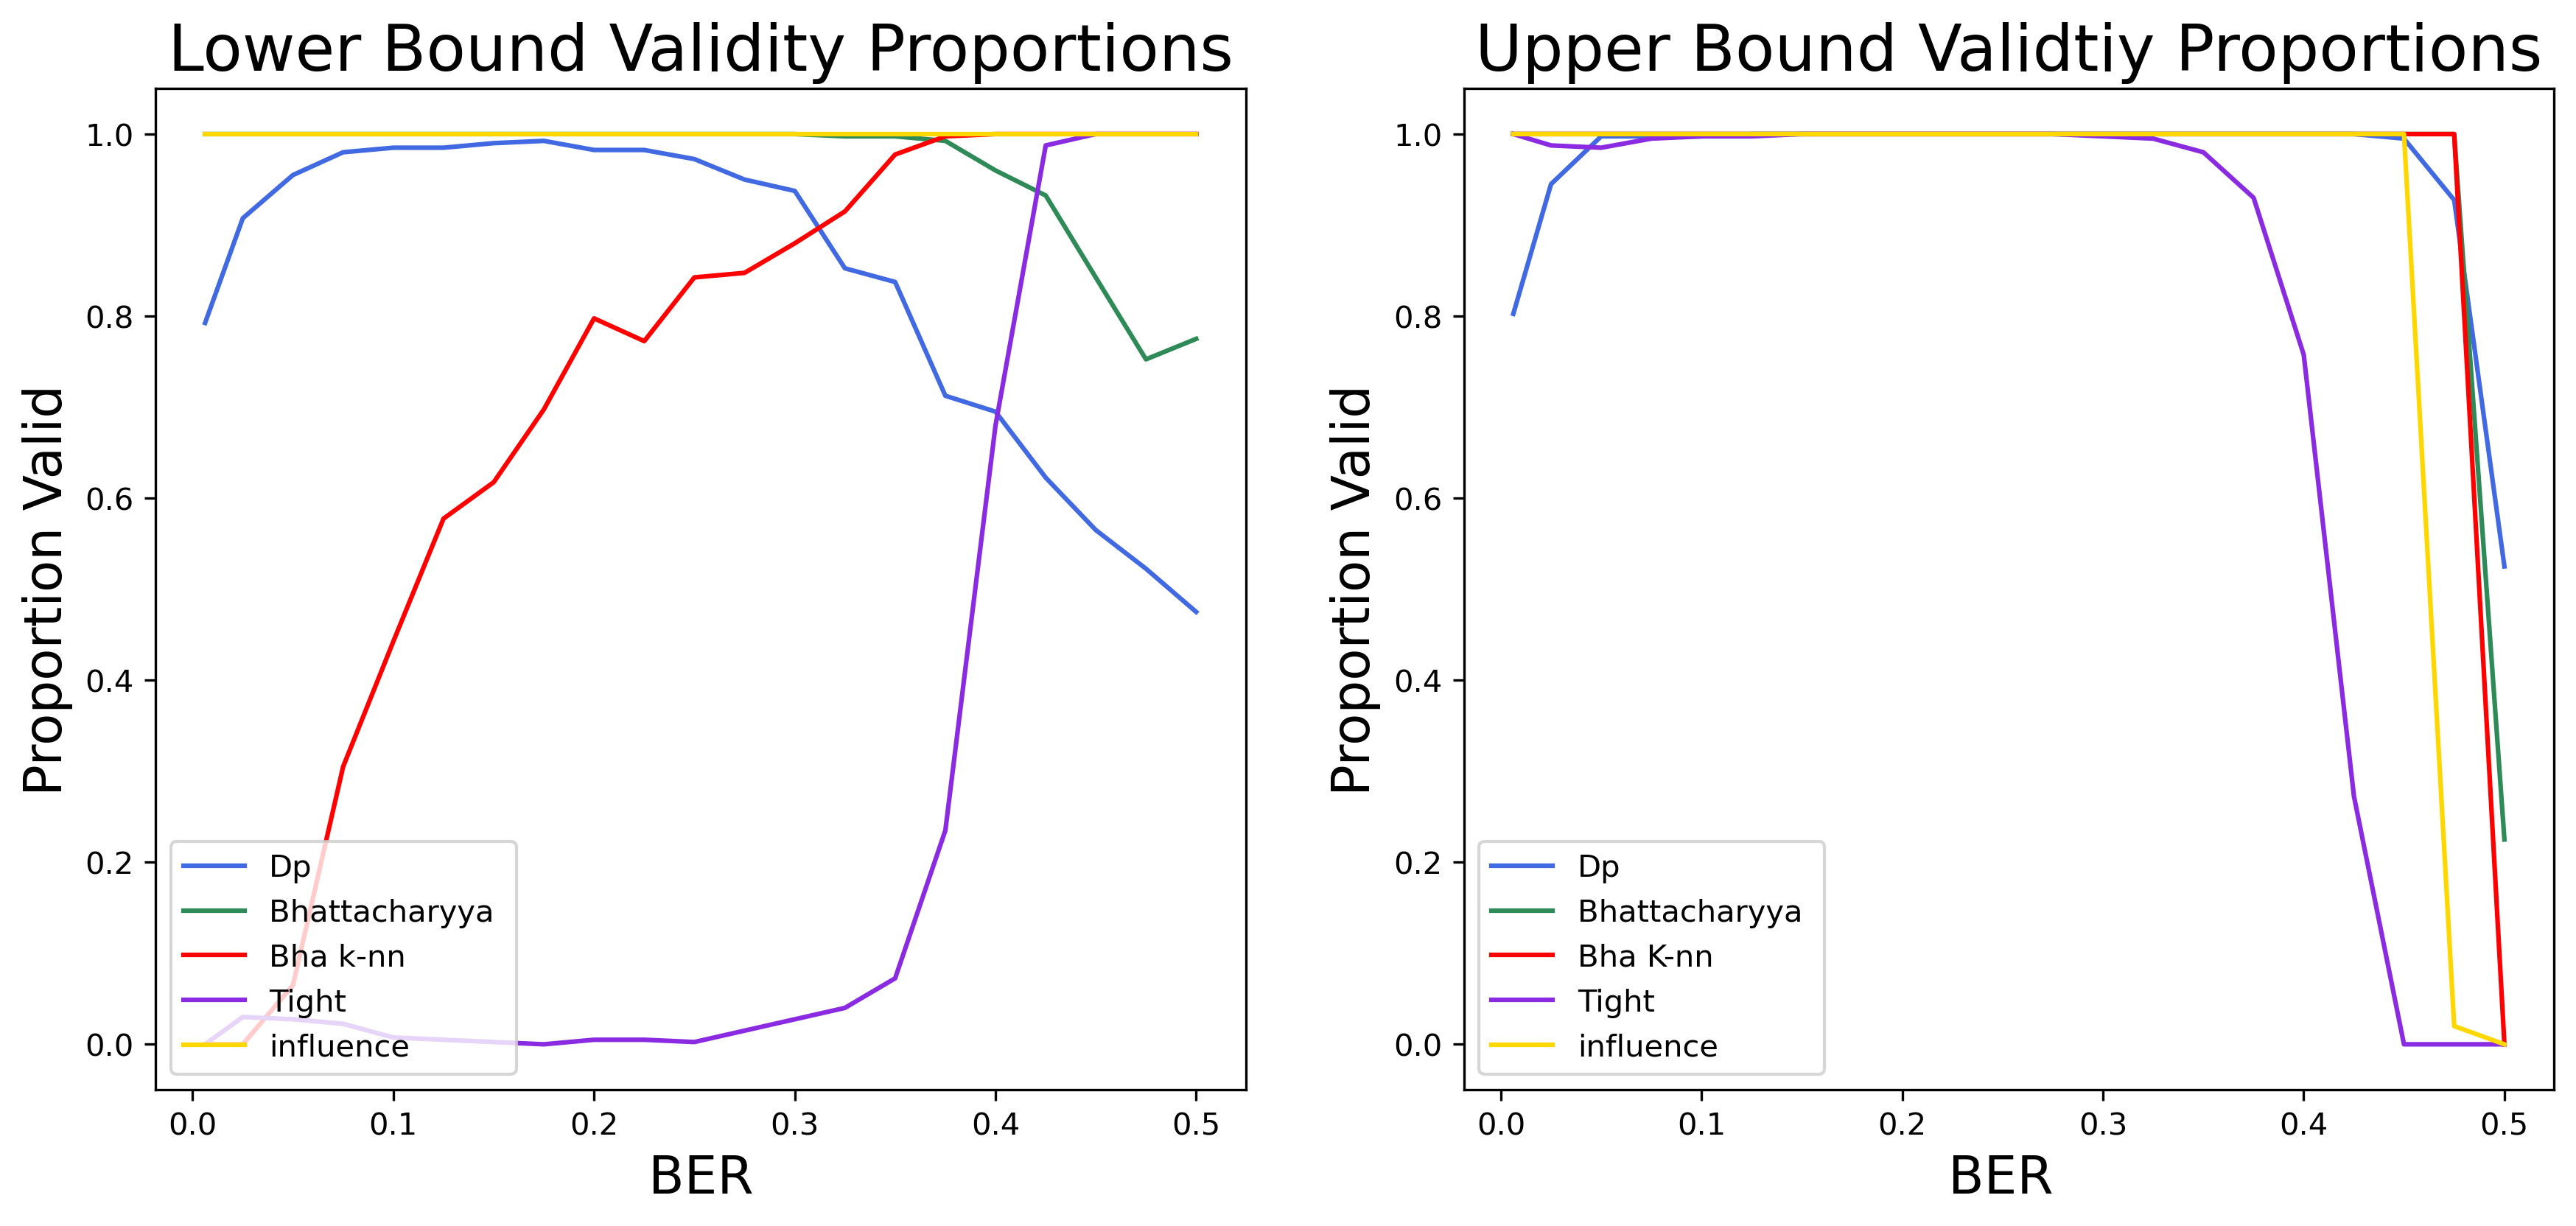

In [17]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), dpi = dpi)

ax = axes[0]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(df['Dp_lower'], 'royalblue',  label='Dp')

ax.plot(df['Bha_lower'],'seagreen', label='Bhattacharyya ')

ax.plot(df['Bha_knn_lower'],'r', label='Bha k-nn ')

ax.plot(df['tight_lower'], 'blueviolet', label='Tight ')

ax.plot(df['inf_lower'], 'gold', label= 'influence')

ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Proportion Valid", fontsize=fs)
ax.set_title("Lower Bound Validity Proportions" , fontsize = fs +4)
ax.legend(loc=3)



ax = axes[1]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(df['Dp_upper'], 'royalblue',  label='Dp')

ax.plot(df['Bha_upper'],'seagreen', label='Bhattacharyya ')

ax.plot(df['Bha_knn_upper'],'r', label='Bha K-nn ')

ax.plot(df['tight_upper'], 'blueviolet', label='Tight ')

ax.plot(df['inf_upper'], 'gold', label= 'influence')
# ax.set_ylim([.4, 1.025])
# ax.set_yticks(np.linspace(.5,1,6))


ax.set_xlabel("BER ", fontsize = fs)
ax.set_ylabel("Proportion Valid", fontsize=fs)
ax.set_title("Upper Bound Validtiy Proportions" , fontsize = fs +4)
ax.legend(loc=3)


# plt.savefig("proportions_v2.jpeg",facecolor=(1,1,1,1))
plt.show()

### Plotting using dim 8 

In [18]:

df = pd.DataFrame([obj() for obj in bound_obj_lst2], index = exact)


In [19]:
dpi = 400
fs =17

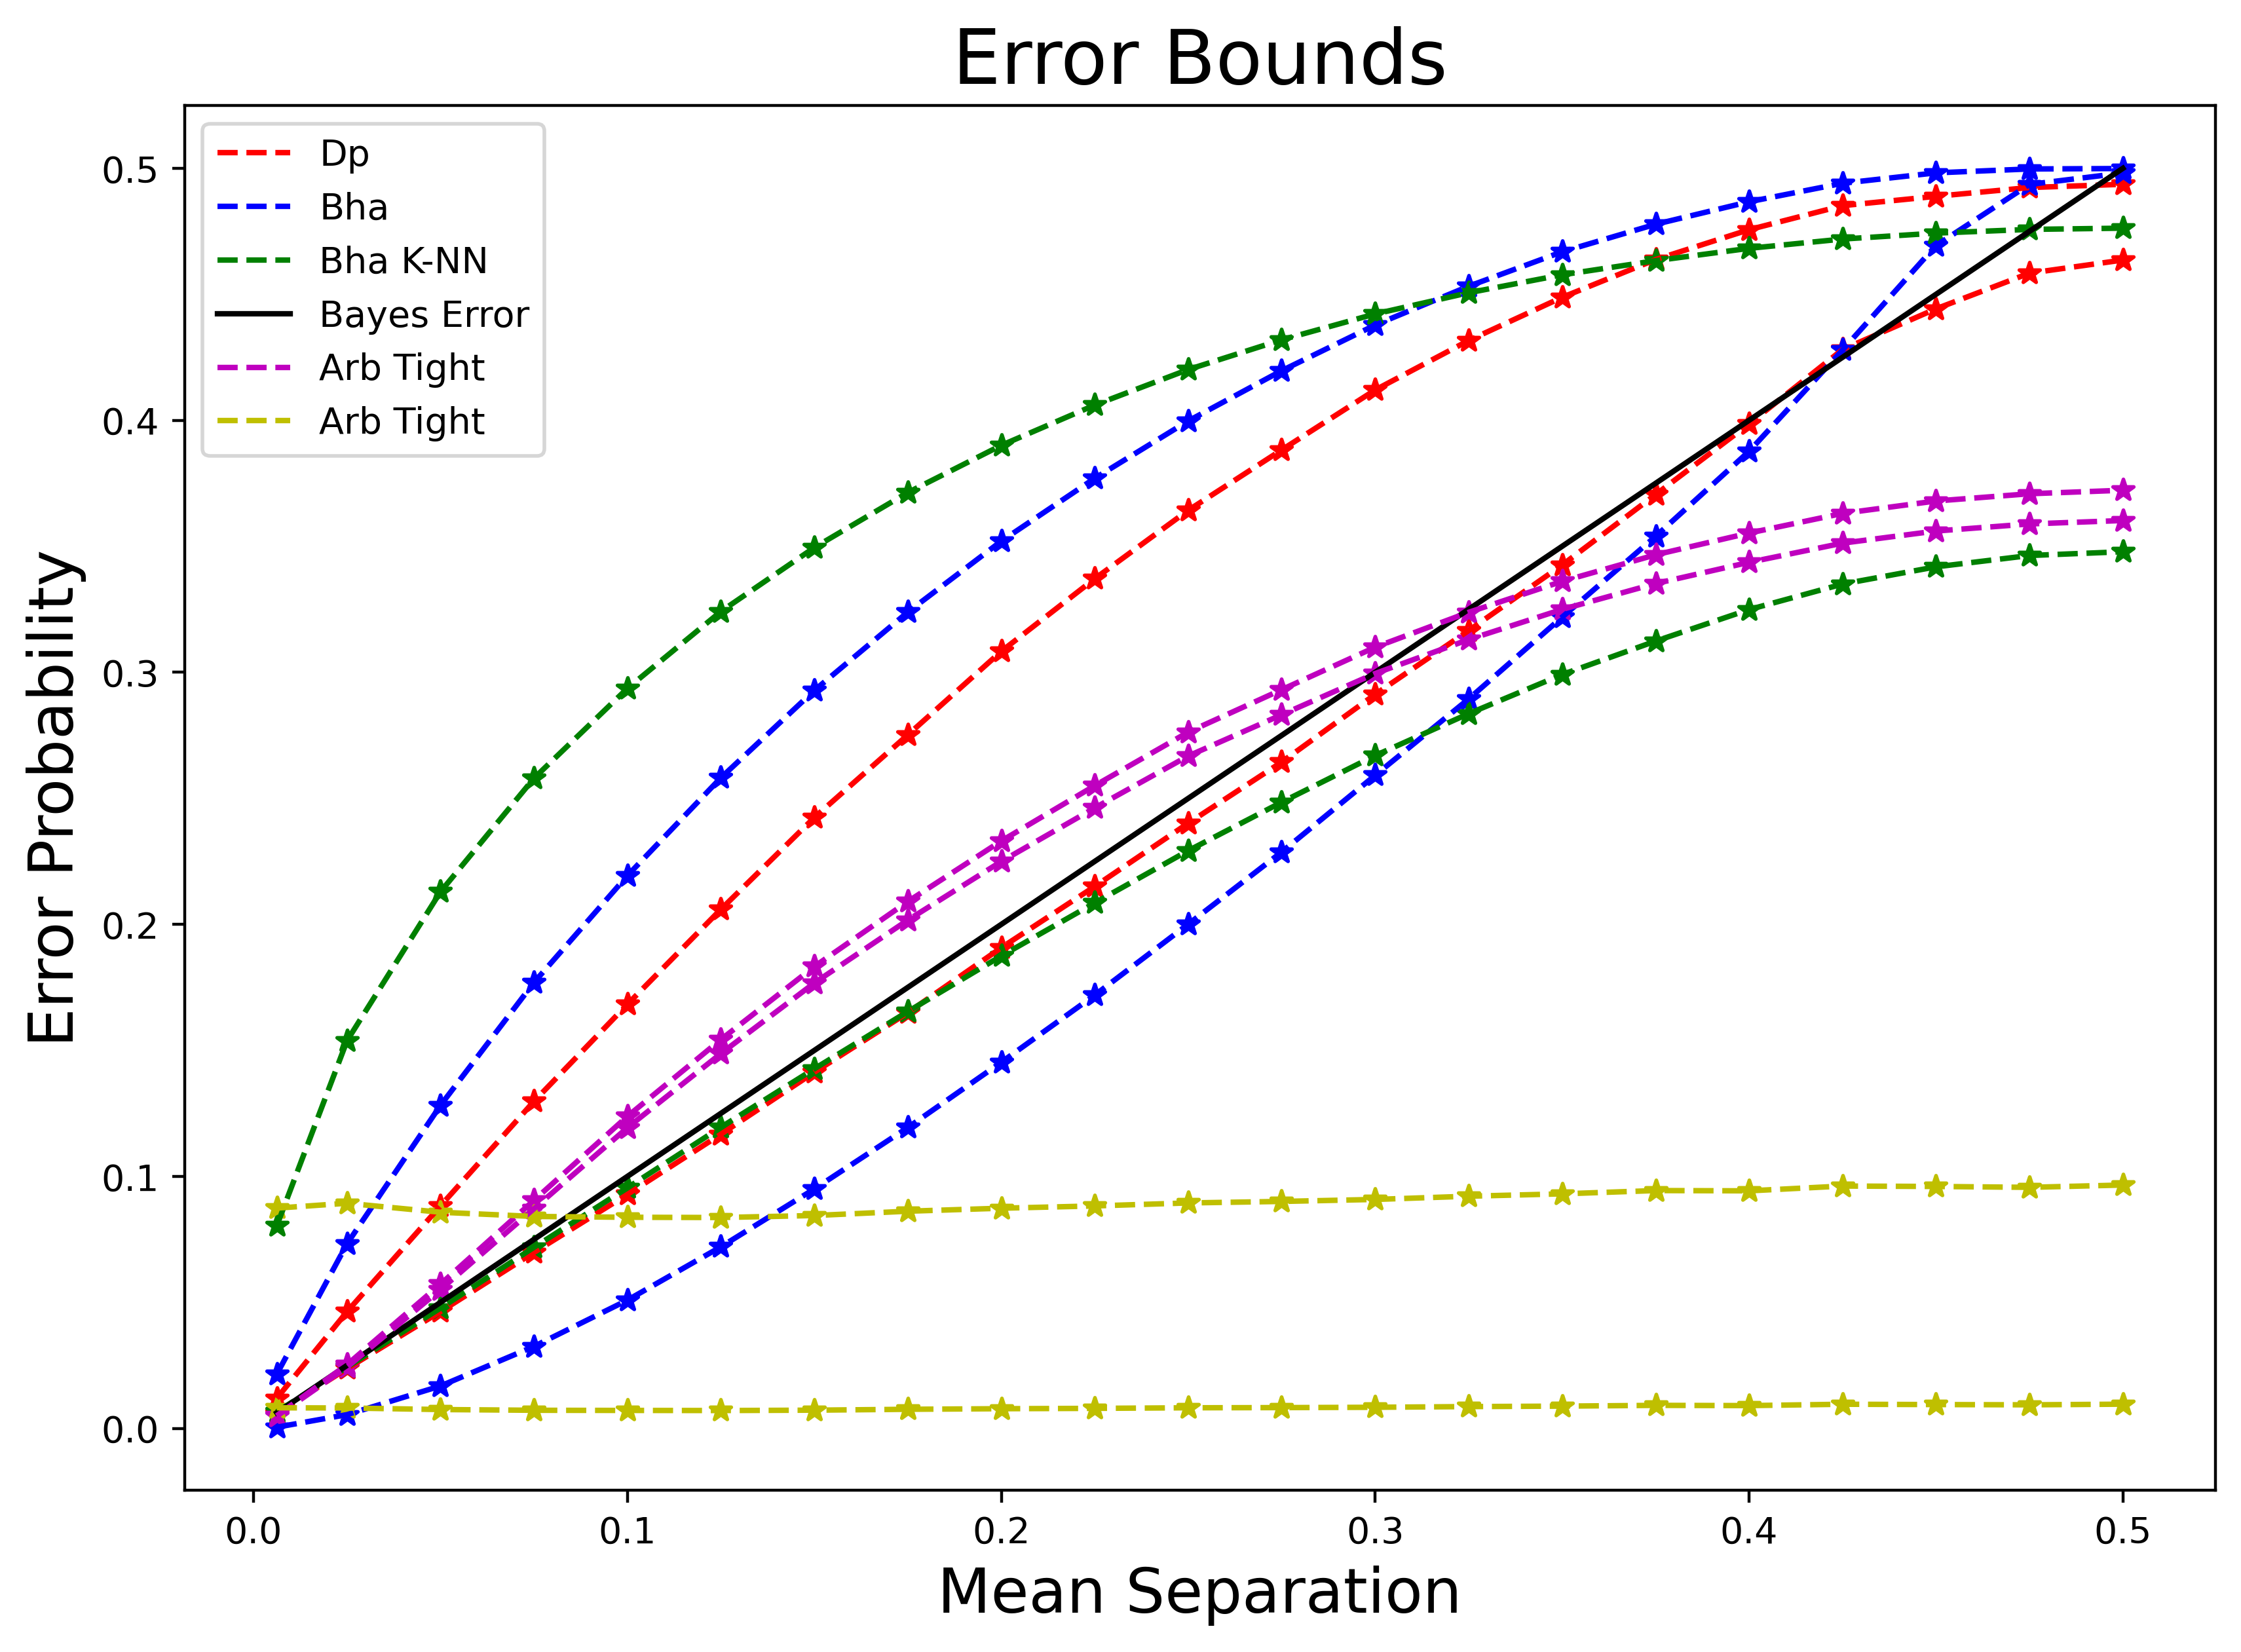

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7), dpi = dpi)


# Plot Dp
ax.plot(df["Dp_lower"], 'r--', label='Dp')
ax.plot(df["Dp_upper"], 'r--')
ax.scatter(df.index, df["Dp_lower"], color='r', marker='*')
ax.scatter(df.index, df["Dp_upper"], color='r', marker='*')

# Plot Bha
ax.plot(df["Bha_lower"], 'b--', label='Bha')
ax.plot(df["Bha_upper"], 'b--')
ax.scatter(df.index, df["Bha_upper"], color='b', marker='*')
ax.scatter(df.index, df["Bha_lower"], color='b', marker='*')

# Plot Bha K-NN
ax.plot(df["Bha_knn_lower"], 'g--')
ax.plot(df["Bha_knn_upper"], 'g--', label='Bha K-NN')
ax.scatter(df.index, df["Bha_knn_upper"], color='g', marker='*')
ax.scatter(df.index, df["Bha_knn_lower"], color='g', marker='*')

# Plot Bayes Error
ax.plot(exact, exact, 'k', label='Bayes Error')

# Plot Lower and Upper G_a
ax.plot(df["tight_lower"], 'm--', label="Arb Tight")
ax.plot(df["tight_upper"], 'm--')
ax.scatter(df.index, df["tight_lower"], color='m', marker='*')
ax.scatter(df.index, df["tight_upper"], color='m', marker='*')

# Plot Maha
# ax.plot( df["Maha_upper"], 'y--', label='Maha')
# ax.scatter(df.index, df["Maha_upper"], color='y', marker='*')

# Plot Lower and Upper G_a
ax.plot(df["inf_lower"], 'y--', label="Arb Tight")
ax.plot(df["inf_upper"], 'y--')
ax.scatter(df.index, df["inf_lower"], color='y', marker='*')
ax.scatter(df.index, df["inf_upper"], color='y', marker='*')


ax.set_xlabel("Mean Separation", fontsize=fs)
ax.set_ylabel("Error Probability", fontsize=fs)
ax.set_title("Error Bounds", fontsize=fs + 4)
ax.legend()

plt.show()

In [21]:
validity_lst  =[]
for i in range(len(exact)):
    validity_lst.append(bound_obj_lst2[i].validity(exact[i]))
    
import pandas as pd
df = pd.DataFrame(validity_lst, index = exact)
df

,Dp_lower,Dp_upper,Bha_lower,Bha_upper,Bha_knn_lower,Bha_knn_upper,tight_lower,tight_upper,Maha_upper,inf_lower,inf_upper
0.006210,0.5875,0.9275,1.0000,1.00,0.3975,1.000,0.8600,0.1600,1.0,0.31,1.0000
0.025001,0.6225,0.9950,1.0000,1.00,0.6200,1.000,0.5950,0.4650,1.0,1.00,1.0000
0.049994,0.7050,1.0000,1.0000,1.00,0.7025,1.000,0.3425,0.7025,1.0,1.00,1.0000
0.074984,0.7525,1.0000,1.0000,1.00,0.6825,1.000,0.1700,0.8800,1.0,1.00,1.0000
0.099987,0.7525,1.0000,1.0000,1.00,0.7325,1.000,0.1125,0.9425,1.0,1.00,0.0125
0.124997,0.7700,1.0000,1.0000,1.00,0.7450,1.000,0.0775,0.9525,1.0,1.00,0.0075
0.150019,0.7675,1.0000,1.0000,1.00,0.7950,1.000,0.0500,0.9750,1.0,1.00,0.0075
0.174999,0.7900,1.0000,1.0000,1.00,0.8475,1.000,0.0600,0.9750,1.0,1.00,0.0000
0.200010,0.7775,1.0000,1.0000,1.00,0.8950,1.000,0.0775,0.9625,1.0,1.00,0.0000
0.225027,0.7275,1.0000,1.0000,1.00,0.9625,1.000,0.1100,0.9625,1.0,1.00,0.0000


In [22]:
# print(validity_dp_l,  validity_dp_u, validity_Bha_l, validity_Bha_u, validity_tight_l, validity_tight_u )

Upper bound Validity

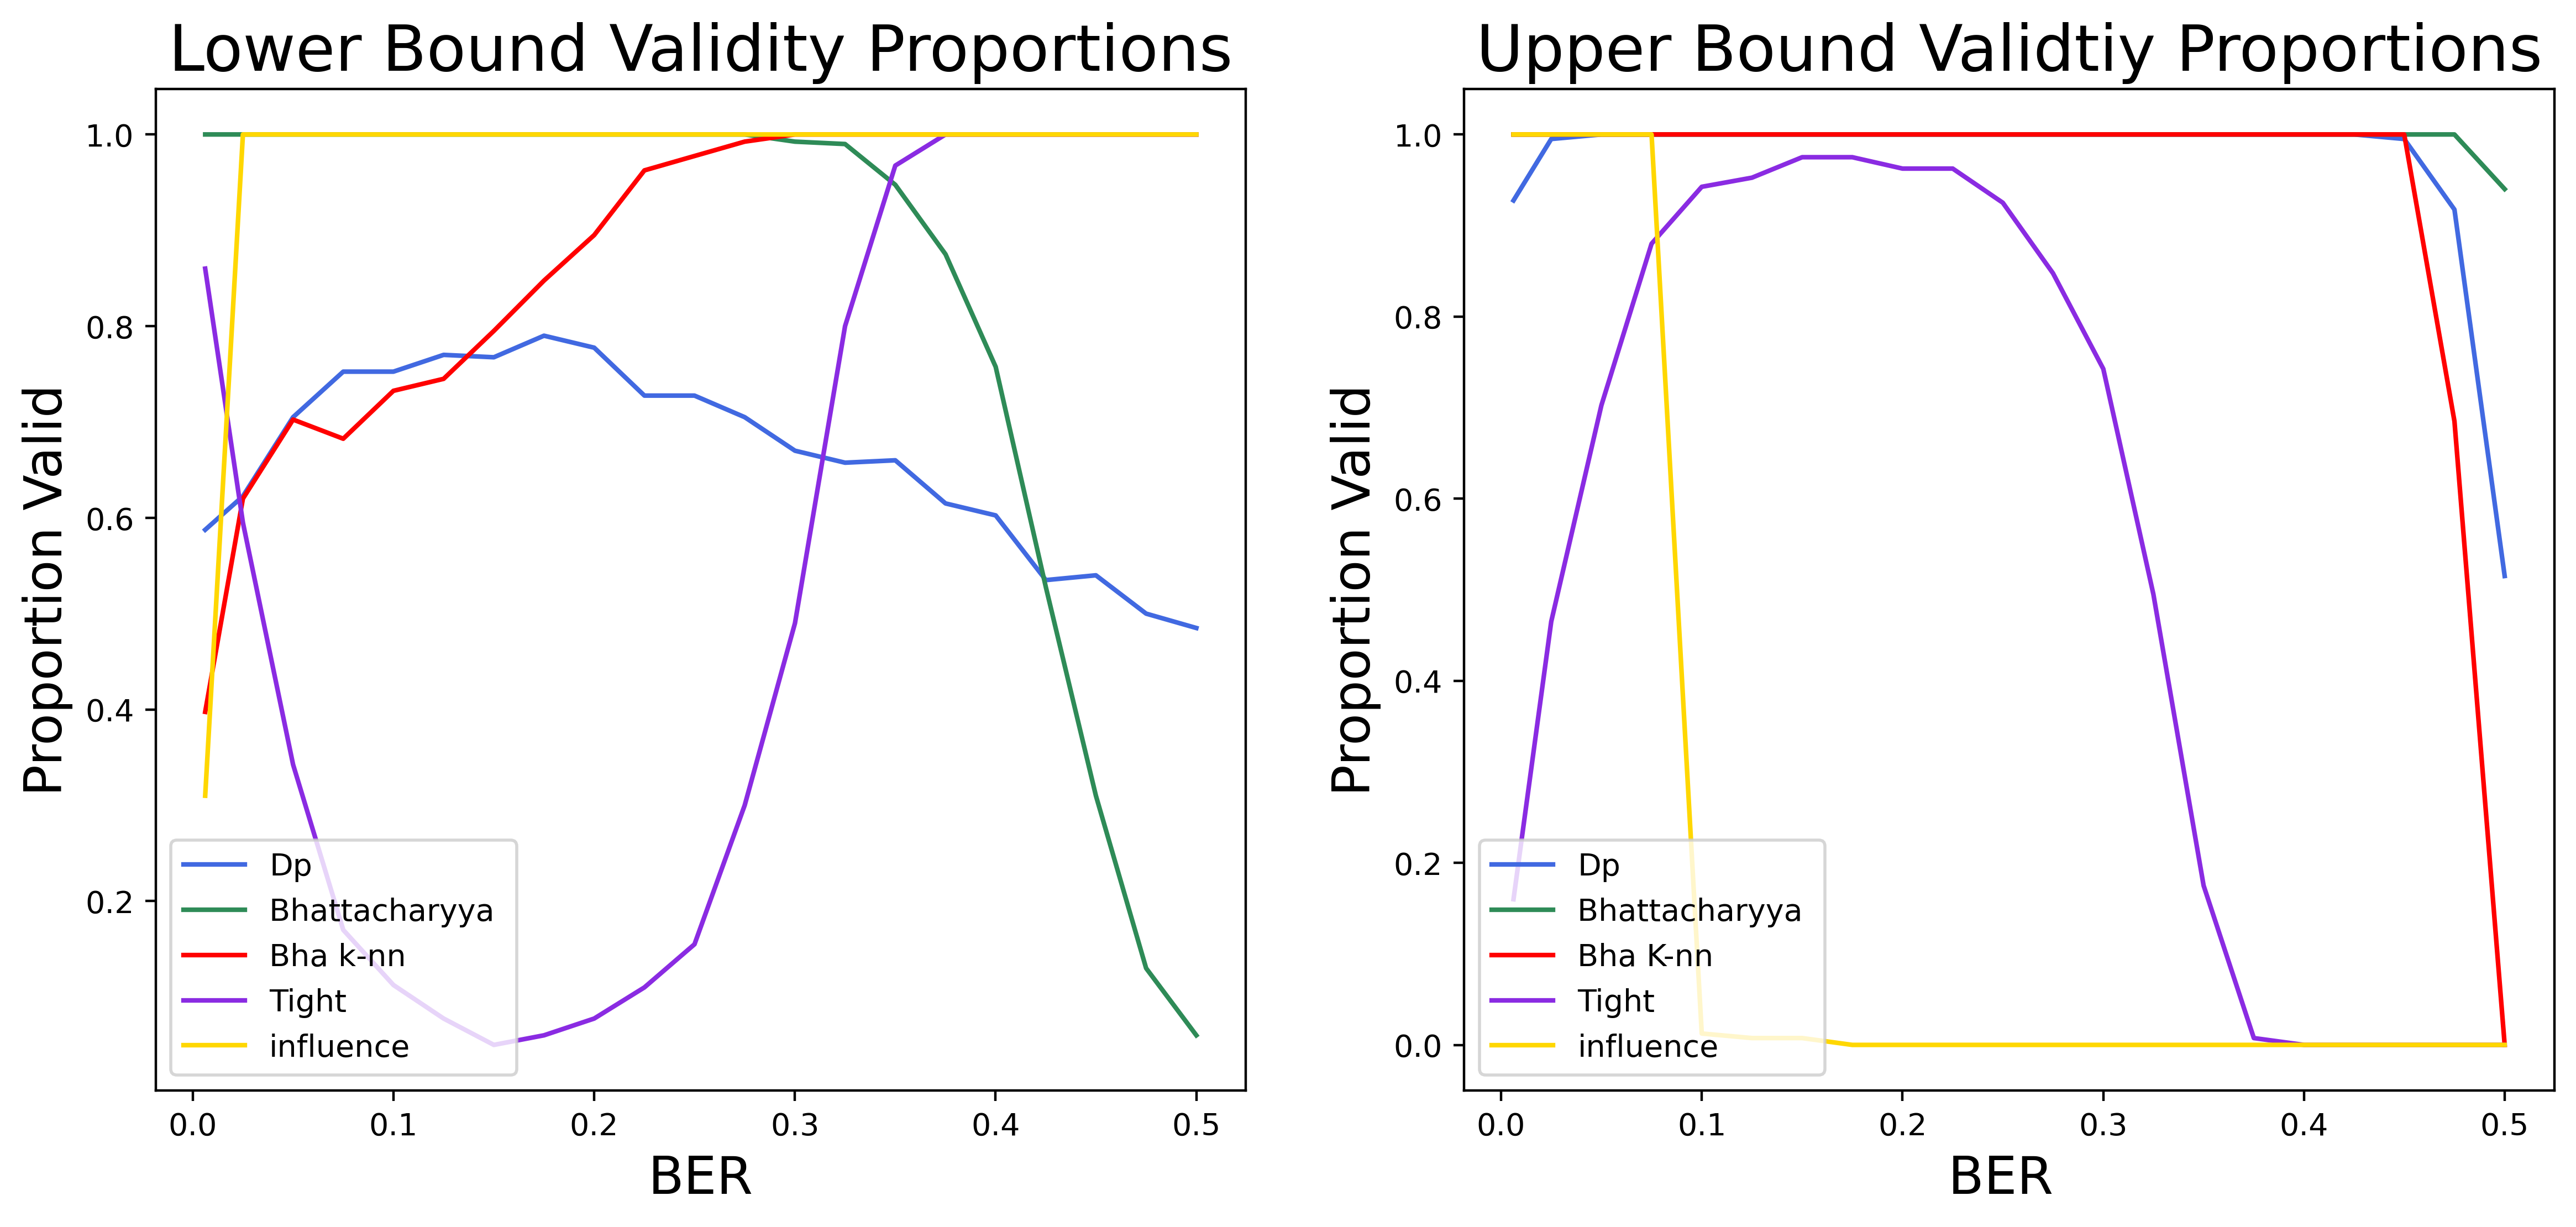

In [23]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), dpi = dpi)

ax = axes[0]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(df['Dp_lower'], 'royalblue',  label='Dp')

ax.plot(df['Bha_lower'],'seagreen', label='Bhattacharyya ')

ax.plot(df['Bha_knn_lower'],'r', label='Bha k-nn ')

ax.plot(df['tight_lower'], 'blueviolet', label='Tight ')

ax.plot(df['inf_lower'], 'gold', label= 'influence')

ax.set_xlabel("BER", fontsize = fs)
ax.set_ylabel("Proportion Valid", fontsize=fs)
ax.set_title("Lower Bound Validity Proportions" , fontsize = fs +4)
ax.legend(loc=3)



ax = axes[1]

# ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)


ax.plot(df['Dp_upper'], 'royalblue',  label='Dp')

ax.plot(df['Bha_upper'],'seagreen', label='Bhattacharyya ')

ax.plot(df['Bha_knn_upper'],'r', label='Bha K-nn ')

ax.plot(df['tight_upper'], 'blueviolet', label='Tight ')

ax.plot(df['inf_upper'], 'gold', label= 'influence')
# ax.set_ylim([.4, 1.025])
# ax.set_yticks(np.linspace(.5,1,6))


ax.set_xlabel("BER ", fontsize = fs)
ax.set_ylabel("Proportion Valid", fontsize=fs)
ax.set_title("Upper Bound Validtiy Proportions" , fontsize = fs +4)
ax.legend(loc=3)


# plt.savefig("proportions_v2.jpeg",facecolor=(1,1,1,1))
plt.show()